In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os
import sys 

project_dir_path = '/home/onoue/ws/lukasiewicz_1'
sys.path.append(project_dir_path)

import cvxpy as cp 
import numpy as np 
import pandas as pd 

from src.setup_problem_dual import Setup
from src.setup_problem_dual import ObjectiveFunction
from src.setup_problem_dual import Predicate_dual

In [35]:
data_dir_path = "./../../inputs/toy_data_loss" # たまたまファイル名が都合よいだけで，loss 関数は関係がない

file_names_dict = {
    'supervised': ['L_p1.csv', 'L_p2.csv', 'L_p3.csv'],
    'unsupervised': ['U.csv'],
    'rule': ['rules.txt']
}

problem_instance = Setup(data_dir_path, file_names_dict, ObjectiveFunction, c1=10, c2=10)
objective, constraints = problem_instance.main()

problem = cp.Problem(objective, constraints)
result = problem.solve(verbose=True)

load_data took 0.011217832565307617 seconds!
load_rules took 0.003435373306274414 seconds!
formulate_predicates_with_cvxpy took 0.0005810260772705078 seconds!
_construct_P took 0.051149845123291016 seconds!
construct_constraints took 0.05926227569580078 seconds!
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 24 12:05:41 AM: Your problem has 96 variables, 135 constraints, and 0 parameters.
(CVXPY) Dec 24 12:05:41 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 24 12:05:41 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 24 12:05:41 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation              

(CVXPY) Dec 24 12:05:41 AM: Applying reduction OSQP
(CVXPY) Dec 24 12:05:41 AM: Finished problem compilation (took 3.387e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Dec 24 12:05:41 AM: Invoking solver OSQP  to obtain a solution.
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 162, constraints m = 297
          nnz(P) + nnz(A) = 1068
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (

# 切片 $b_j$ の値の調整ができていない気がする 

In [36]:
p1 = Predicate_dual(problem_instance, 'p1')
X = problem_instance.L['p1'][:, :-1]
Y = problem_instance.L['p1'][:, -1]
for x, y in zip(X, Y):
    print(x, y, p1(x))

[0.1 0.5] -1.0 -0.1749513617619951
[0.4 0.4] -1.0 -0.1499873602538544
[0.3 0.8] 1.0 0.5750137019089703
[0.9 0.7] 1.0 0.8249387220158491


In [37]:
p2 = Predicate_dual(problem_instance, 'p2')
X = problem_instance.L['p2'][:, :-1]
Y = problem_instance.L['p2'][:, -1]
for x, y in zip(X, Y):
    print(x, y, p2(x))

[0.1 0.3] -1.0 -0.27228267304232723
[0.6 0.4] -1.0 0.04464961915089438
[0.2 0.8] 1.0 0.7276330538914335
[0.7 0.6] 1.0 0.45923455327520224


In [38]:
p3 = Predicate_dual(problem_instance, 'p3')
X = problem_instance.L['p3'][:, :-1]
Y = problem_instance.L['p3'][:, -1]
for x, y in zip(X, Y):
    print(x, y, p3(x))

[0.4 0.2] -1.0 5.5232701568597165e-05
[0.9 0.3] -1.0 0.19983622227772913
[0.2 0.6] 1.0 0.8001209696041875
[0.5 0.7] 1.0 0.9999875754165142


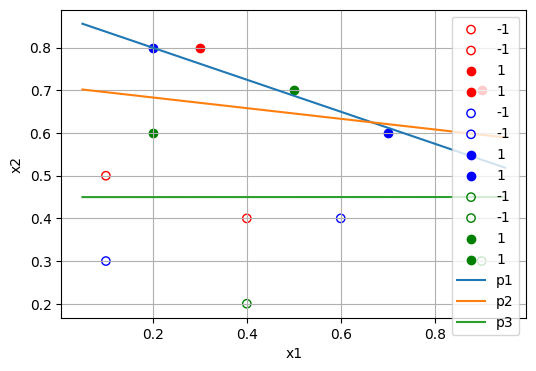

In [39]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(6,4))

p1 = Predicate_dual(problem_instance, 'p1')
p2 = Predicate_dual(problem_instance, 'p2')
p3 = Predicate_dual(problem_instance, 'p3')



ps = [p1, p2, p3]

test_x = np.linspace(0.05, 0.95, 100).reshape(-1, 1)
test_ys = []

for p in ps:
    w1 = p.coeff[0]
    w2 = p.coeff[1]
    b  = p.coeff[2]

    x = np.hstack([test_x, np.ones_like(test_x)])
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    test_ys.append(x @ w)


colors = ['red', 'blue', 'green']


for p, c in zip(ps, colors):
    for l in range(4):
        if p.L[l, -1] == 1:
            plt.scatter(p.L[l, 0], p.L[l, 1], c=c, marker='o', label='1')
        else:
            plt.scatter(p.L[l, 0], p.L[l, 1], facecolors='none', edgecolors=c, marker='o', label='-1')
        
for j, test_y in enumerate(test_ys):
    plt.plot(test_x, test_y, label=f'p{j+1}')

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
p1.coeff

array([ 0.74987006,  1.99997017, -1.24992345])

In [11]:
p2.w_linear_kernel, p2.b

(array([0.24364406, 1.95110264]), -0.8819778714364581)

In [10]:
p3.w_linear_kernel, p3.b

(array([-4.28081181e-04,  1.99995030e+00]), -0.3997635951592775)

In [14]:
p1.L

array([[ 0.1,  0.5, -1. ],
       [ 0.4,  0.4, -1. ],
       [ 0.3,  0.8,  1. ],
       [ 0.9,  0.7,  1. ]])

In [ ]:
from src.misc import boundary_equation_2d


def visualize_result(, colors=['red', 'blue', 'green', 'yellow', 'black']) -> None:
    """
    入力データの次元が 2 のときのみ使用可能
    """
    L = problem_instance.L
    w_j = problem_instance.w_j.value
    len_j = problem_instance.len_j
    len_l = problem_instance.len_l

    test_x = np.linspace(0.05, 0.95, 100).reshape(-1, 1)
    test_ys = []
    for w in w_j:
        test_ys.append(boundary_equation_2d(test_x, w))

    plt.figure(figsize=(6,4))
    
    for j, p_name in enumerate(problem_instance.predicates_dict.keys()):
        for l in range(len_l):
            if L[p_name][l, 2] == 1:
                plt.scatter(L[p_name][l,0], L[p_name][l,1], c=colors[j], marker='o', label='1')
            else:
                plt.scatter(L[p_name][l,0], L[p_name][l,1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

    for j, test_y in enumerate(test_ys):
        plt.plot(test_x, test_y, label=f'p{j+1}')
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
array([[ 7.50000000e-01,  2.00000000e+00, -1.07500000e+00],
       [ 3.19767438e-01,  1.93604651e+00, -6.12790698e-01],
       [ 1.09409846e-10,  2.00000000e+00, -4.00000000e-01]])

# $b_j$ に 0.5 を足してみる (0 を閾値にする)

In [18]:
p1 = Predicate_dual(problem_instance, 'p1')
X = problem_instance.L['p1'][:, :-1]
Y = problem_instance.L['p1'][:, -1]
for x, y in zip(X, Y):
    print(x, y, p1(x))

b: -1.7499373259309368
[0.1 0.5] -1.0 -0.1749766844491083
[0.4 0.4] -1.0 -0.14998720532296783
[0.3 0.8] 1.0 0.574991653687335
[0.9 0.7] 1.0 0.8249638897720766


In [19]:
p2 = Predicate_dual(problem_instance, 'p2')
X = problem_instance.L['p2'][:, :-1]
Y = problem_instance.L['p2'][:, -1]
for x, y in zip(X, Y):
    print(x, y, p2(x))

b: -0.38923786217070516
[0.1 0.3] -1.0 0.32230386117932097
[0.6 0.4] -1.0 0.4323078205647723
[0.2 0.8] 1.0 0.6692319641528715
[0.7 0.6] 1.0 0.5761563541030352


In [20]:
p3 = Predicate_dual(problem_instance, 'p3')
X = problem_instance.L['p3'][:, :-1]
Y = problem_instance.L['p3'][:, -1]
for x, y in zip(X, Y):
    print(x, y, p3(x))

b: -0.22497168048434366
[0.4 0.2] -1.0 0.37500491911111916
[0.9 0.3] -1.0 0.42497497036294196
[0.2 0.6] 1.0 0.5750189467884236
[0.5 0.7] 1.0 0.6250011637375155


In [19]:
np.ones(2)

array([1., 1.])

In [5]:
import matplotlib.pyplot as plt

In [ ]:
test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

In [15]:
np.random.rand(2,4).shape

(2, 4)

In [18]:
np.random.rand(2).shape

(2,)

# カーネルを非線形のものにして，pima indian に対して適用してみる

In [6]:
data_dir_path = os.path.join(project_dir_path, 'inputs/pima_indian_diabetes')
train_data_dir_path = os.path.join(data_dir_path, "train")
file_list = os.listdir(train_data_dir_path)

L_files = [filename for filename in file_list 
           if filename.startswith('L') and filename.endswith('.csv')]

U_files = [filename for filename in file_list 
           if filename.startswith('U') and filename.endswith('.csv')]

file_names_dict = {
    'supervised': L_files,
    'unsupervised': U_files,
    'rule': ['rules.txt']
}

In [9]:
problem_instance = Setup(train_data_dir_path, file_names_dict, ObjectiveFunction)
objective, constraints = problem_instance.main()

problem = cp.Problem(objective, constraints)
result = problem.solve(verbose=True)

load_data took 0.14220952987670898 seconds!
load_rules took 0.08345651626586914 seconds!
formulate_predicates_with_cvxpy took 0.0009579658508300781 seconds!


KeyboardInterrupt: 

In [ ]:
test_data_dir_path = os.path.join(data_dir_path, "test")
file_path = os.path.join(test_data_dir_path, "L_Outcome.csv")
test_df = pd.read_csv(file_path, index_col=0)

p = Predicate_dual(problem_instance, 'Outcome')
